In [1]:
from google.colab import drive
drive.mount('/content/drive')

#Connect to the Google Drive

Mounted at /content/drive


Connect to the google Drive

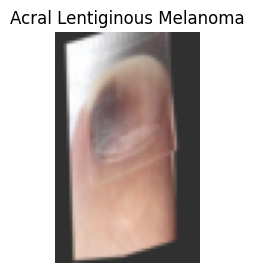

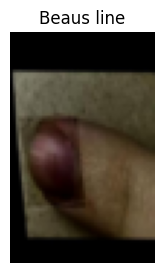

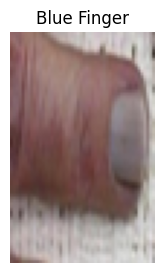

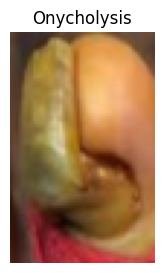

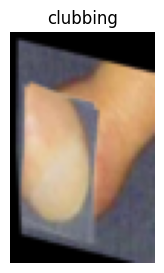

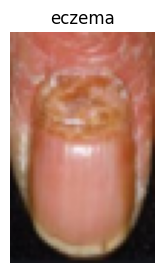

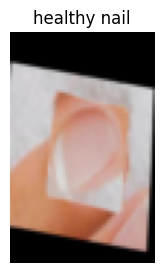

In [2]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Set the path to your dataset
src_path = "/content/drive/MyDrive/4th Year Research Project Practical/Weekly Practical/Nail Disease datasets/train"

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((80, 50)),  # Adjust desired_height and desired_width
    transforms.ToTensor(),
])

# Load the dataset
dataset = ImageFolder(root=src_path, transform=transform)

# Map class names to indices
class_to_idx = {class_name: idx for idx, class_name in enumerate(dataset.classes)}

# Create a dataloader for each class
class_dataloaders = []
for class_name in dataset.classes:
    class_indices = [i for i, label in enumerate(dataset.targets) if dataset.classes[label] == class_name]
    class_dataset = torch.utils.data.Subset(dataset, class_indices)
    class_dataloader = DataLoader(class_dataset, batch_size=1, shuffle=True)
    class_dataloaders.append((class_name, class_dataloader))

# Display one image from each class separately
for class_name, class_dataloader in class_dataloaders:
    fig, axes = plt.subplots(1, 1, figsize=(3, 3))

    # Display one image from the current class
    images, labels = next(iter(class_dataloader))
    image_np = images.numpy().squeeze().transpose((1, 2, 0))

    axes.imshow(image_np)
    axes.set_title(class_name)
    axes.axis('off')

    plt.show()


In [3]:
print(len(dataset))

3081


In [4]:
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms

class CNNModel(nn.Module):
    def __init__(self, num_classes=7):
        super(CNNModel, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Adaptive pooling layer
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc1 = nn.Linear(64, 512)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))

        # Adaptive pooling to handle variable input sizes
        x = self.adaptive_pool(x)

        # Flatten the tensor before the fully connected layer
        x = x.view(x.size(0), -1)

        # Fully connected layers with dropout
        x = self.relu3(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Define the transformations to resize the images
transform = transforms.Compose([
    transforms.Resize((64, 50)),  # Adjust the target size based on your requirements
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])


src_path = "/content/drive/MyDrive/4th Year Research Project Practical/Weekly Practical/Nail Disease datasets/train"

dataset = ImageFolder(root=src_path, transform=transform)
train_size = int(0.8 * len(dataset))
train_dataset, val_dataset = random_split(dataset, [train_size, len(dataset) - train_size])

# Initialize the model
model = CNNModel(num_classes=7)

# Define your loss function and optimizer
class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# DataLoader for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=20, shuffle=True)

# Active learning loop
num_active_iterations = 100
initial_labeled_size = 500  # Adjust this based on your dataset size

# Initial labeled dataset
initial_labeled_dataset, remaining_unlabeled_dataset = random_split(train_dataset, [initial_labeled_size, len(train_dataset) - initial_labeled_size])

for iteration in range(num_active_iterations):
    # Train the model on the current labeled dataset
    model.train()
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validate the model on the validation set
    model.eval()
    with torch.no_grad():
        val_correct = 0
        val_total = 0
        for val_inputs, val_labels in val_dataloader:
            val_outputs = model(val_inputs)
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

        val_accuracy = val_correct / val_total
        print(f'Validation Accuracy at Iteration {iteration + 1}: {val_accuracy}')

    # Active learning strategy: Least Confidence Sampling
    least_confidence_samples = []
    model.eval()
    with torch.no_grad():
        for unlabeled_inputs, _ in remaining_unlabeled_dataset:
            unlabeled_outputs = model(unlabeled_inputs.unsqueeze(0))  # Unsqueezing to add a batch dimension
            probabilities = nn.functional.softmax(unlabeled_outputs, dim=1)
            confidence, predicted_class = torch.max(probabilities, 1)
            least_confidence_samples.append((confidence.item(), unlabeled_inputs))

    # Check if there are samples in least_confidence_samples
    if not least_confidence_samples:
        print("No more samples in the unlabeled dataset. Stopping active learning.")
        break

    # Sort samples based on least confidence
    least_confidence_samples.sort(key=lambda x: x[0])

    # Select the least confident sample
    selected_sample_confidence, selected_sample_input = least_confidence_samples.pop(0)

    # Manually label the selected sample (replace with actual label)
    # ...
    # In a real scenario, you would replace the next line with the actual class label you assign
    true_label = torch.tensor([2])

    # Retrain the model with the newly labeled sample
    model.train()
    optimizer.zero_grad()
    outputs = model(selected_sample_input.unsqueeze(0))  # Unsqueezing to add a batch dimension
    loss = criterion(outputs, true_label)
    loss.backward()
    optimizer.step()

    # Update the labeled and unlabeled datasets for the next iteration
    initial_labeled_dataset += [(selected_sample_input, true_label)]
    remaining_unlabeled_dataset = [sample for sample in remaining_unlabeled_dataset if sample[0].item() not in [item[1].item() for item in least_confidence_samples]]




Validation Accuracy at Iteration 1: 0.2852512155591572


RuntimeError: ignored

In [ ]:
src_path = "/content/drive/MyDrive/4th Year Research Project Practical/Weekly Practical/Nail Disease datasets/test"

test_dataset = ImageFolder(root=src_path, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=20, shuffle=False)

from sklearn.metrics import confusion_matrix, classification_report

model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for test_inputs, test_labels in test_dataloader:
        test_outputs = model(test_inputs)
        _, test_predicted = torch.max(test_outputs.data, 1)

        all_predictions.extend(test_predicted.numpy())
        all_labels.extend(test_labels.numpy())

conf_matrix = confusion_matrix(all_labels, all_predictions)
classification_rep = classification_report(all_labels, all_predictions)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)


Confusion Matrix:
[[ 0  0  0  0  0  0 42]
 [ 0  0  0  0  0  0 78]
 [ 0  0  0  0  0  0 64]
 [ 0  0  0  0  0  0 70]
 [ 0  0  0  0  0  0 44]
 [ 0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0 66]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.00      0.00      0.00        78
           2       0.00      0.00      0.00        64
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        44
           5       0.00      0.00      0.00        10
           6       0.18      1.00      0.30        66

    accuracy                           0.18       374
   macro avg       0.03      0.14      0.04       374
weighted avg       0.03      0.18      0.05       374



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
plt.plot(training_losses, label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()